<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/jvcqp2iy2jlx2b32rmzdt0tx8lvxgzkp.png" width = 300> </a>

<h1 align=center><font size = 5> LOGISTIC REGRESSION WITH TENSORFLOW </font></h1>

## Table of Contents

Logistic Regression is one of most important techniques in data science. It is usually used to solve the classic classification problem.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3><strong>This lesson covers the following concepts of Logistics Regression:</strong></font>
<br>
- <p><a href="#ref1">Linear Regression vs Logistic Regression</a></p>
- <p><a href="#ref2">Utilizing Logistic Regression in TensorFlow</a></p>
- <p><a href="#ref3">Training</a></p>
<p></p>
</div>
----------------

<a id="ref1"></a>
## What is different between Linear and Logistic Regression?

While Linear Regression is suited for estimating continuous values (e.g. estimating house price), it isn’t the best tool for predicting the class of an observed data point. In order to estimate a classification, we need some sort of guidance on what would be the **most probable class** for that data point. For this, we use **Logistic Regression**.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size = 3><strong>Recall linear regression:</strong></font>
<br>
<br>
Linear regression finds a function that relates a continuous dependent variable, _y_, to some predictors (independent variables _x1_, _x2_, etc.). Simple linear regression assumes a function of the form:
<br><br>
$$
y = w0 + w1 * x1 + w2 * x2 +...
$$
<br>
and finds the values of _w0_, _w1_, _w2_, etc. The term _w0_ is the "intercept" or "constant term" (it's shown as _b_ in the formula below):
<br><br>
$$
Y = WX + b
$$
<p></p>

</div>

Logistic Regression is a variation of Linear Regression, useful when the observed dependent variable, _y_, is categorical. It produces a formula that predicts the probability of the class label as a function of the independent variables.

Despite the name logistic _regression_, it is actually a __probabilistic classification__ model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1+e^y} = exp(y) / (1+exp(y)) = p 
$$

which produces p-values between 0 (as y approaches minus infinity) and 1 (as y approaches plus infinity). This now becomes a special kind of non-linear regression.

In this equation, _y_ is the regression result (the sum of the variables weighted by the coefficients), `exp` is the exponential function and $\theta(y)$ is the [logistic function](http://en.wikipedia.org/wiki/Logistic_function), also called logistic curve. It is a common "S" shape (sigmoid curve), and was first developed for modelling population growth.

You might also have seen this function before, in another configuration:

$$
ProbabilityOfaClass = \theta(y) = \frac{1}{1+e^{-x}}
$$

So, briefly, Logistic Regression passes the input through the logistic/sigmoid but then treats the result as a probability:

<img
src="https://ibm.box.com/shared/static/kgv9alcghmjcv97op4d6onkyxevk23b1.png", width = "400", align = "center">


-------------------------------

<a id="ref2"></a>
# Utilizing Logistic Regression in TensorFlow

For us to utilize Logistic Regression in TensorFlow, we first need to import whatever libraries we are going to use. To do so, you can run the code cell below.

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Next, we will load the dataset we are going to use. In this case, we are utilizing the `iris` dataset, which is inbuilt -- so there's no need to do any preprocessing and we can jump right into manipulating it. We separate the dataset into _xs_ and _ys_, and then into training _xs_ and _ys_ and testing _xs_ and _ys_, (pseudo-)randomly.

In [31]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)
print("\r\nShape of trainX: {}".format(trainX.shape))
print("Shape of trainY: {}".format(trainY.shape))
print("Shape of testX: {}".format(testX.shape))
print("Shape of testY: {}".format(testY.shape))

print("\nNumber of features: {}".format(trainX.shape[1]))
print("Number of classes: {}".format(trainY.shape[1]))


Shape of trainX: (99, 4)
Shape of trainY: (99, 3)
Shape of testX: (50, 4)
Shape of testY: (50, 3)

Number of features: 4
Number of classes: 3


Now we define x and y. These placeholders will hold our iris data (both the features and label matrices), and help pass them along to different parts of the algorithm. You can consider placeholders as empty shells into which we insert our data. We also need to give them shapes which correspond to the shape of our data. Later, we will insert data into these placeholders by “feeding” the placeholders the data via a “feed_dict” (Feed Dictionary).

### Why use Placeholders?  
1) This feature of TensorFlow allows us to create an algorithm which accepts data and knows something about the shape of the data without knowing the amount of data going in. <br><br>
2) When we insert “batches” of data in training, we can easily adjust how many examples we train on in a single step without changing the entire algorithm.

In [38]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]

# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris has 4 features, so X is a tensor to hold our data.
yGold = tf.placeholder(tf.float32, [None, numLabels]) # This will be our correct answers matrix for 3 classes.

### Set model weights and bias

Much like Linear Regression, we need a shared variable weight matrix for Logistic Regression. We initialize both `W` and `b` as tensors full of zeros. Since we are going to learn `W` and `b`, their initial value doesn't matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they’ve been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training. 

Notice that `W` has a shape of [4, 3] because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. `b` has a shape of [3] so we can add it to the output. Moreover, unlike our placeholders above which are essentially empty shells waiting to be fed data, TensorFlow variables need to be initialized with values, e.g. with zeros.

In [39]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

print("Weight matrices structure:")
print(np.zeros([4, 3]))

print("\nBias matrices structure")
print(np.zeros([3]))

Weight matrices structure:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Bias matrices structure
[0. 0. 0.]


In [40]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))

###  Logistic Regression model

We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

However, for the sake of clarity, we can have it broken into its three main components: 
- a weight times features matrix multiplication operation, 
- a summation of the weighted features and a bias term, 
- and finally the application of a sigmoid function. 

As such, you will find these components defined as three separate operations below.


In [60]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

As we have seen before, the function we are going to use is the _logistic function_ $(\frac{1}{1+e^{-x}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the `nn.sigmoid` function. Effectively, this fits the weighted input with bias into a 0-100 percent curve, which is the probability function we want.

-------------------------------------

<a id="ref3"></a>
# Training

The learning algorithm is how we search for the best weight vector (${\bf w}$). This search is an optimization problem looking for the hypothesis that optimizes an error/cost measure.

__What tell us our model is bad?__  
The Cost or Loss of the model, so what we want is to minimize that. 

__What is the cost function in our model?__  
The cost function we are going to utilize is the Squared Mean Error loss function.

__How to minimize the cost function?__   
We can't use __least-squares linear regression__ here, so we will use [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) instead. Specifically, we will use batch gradient descent which calculates the gradient from all data points in the data set.

### Cost function
Before defining our cost function, we need to define how long we are going to train and how should we define the learning rate.

In [61]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [62]:
# Defining our cost function - Squared Mean Error
# Squared mean error for Actual - Predicted value
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

# Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

Now we move on to actually running our operations. We will start with the operations involved in the prediction phase (i.e. the logistic regression itself).

First, we need to initialize our weights and biases with zeros or random values via the inbuilt Initialization Op, __tf.initialize_all_variables()__. This Initialization Op will become a node in our computational graph, and when we put the graph into a session, then the Op will run and create the variables.

In [63]:
# Create a tensorflow session
sess = tf.Session()

# Initialize our weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:

In [64]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

Now we can define and run the actual training loop, like this:

In [65]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: trainX, yGold: trainY})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.333333, cost 34.3045, change in cost 34.3045
step 10, training accuracy 0.575758, cost 30.0568, change in cost 4.24766
step 20, training accuracy 0.646465, cost 28.1272, change in cost 1.9296
step 30, training accuracy 0.646465, cost 26.4985, change in cost 1.62874
step 40, training accuracy 0.646465, cost 25.1441, change in cost 1.35438
step 50, training accuracy 0.646465, cost 24.0239, change in cost 1.12015
step 60, training accuracy 0.646465, cost 23.0957, change in cost 0.928282
step 70, training accuracy 0.646465, cost 22.3215, change in cost 0.774204
step 80, training accuracy 0.646465, cost 21.6701, change in cost 0.65135
step 90, training accuracy 0.646465, cost 21.1168, change in cost 0.553352
step 100, training accuracy 0.656566, cost 20.6419, change in cost 0.474812
step 110, training accuracy 0.666667, cost 20.2305, change in cost 0.411421
step 120, training accuracy 0.666667, cost 19.8707, change in cost 0.359838
step 130, training accuracy 0.6

__Why don't we plot the cost to see how it behaves?__

C:\Users\surinder.kumar01\AppData\Local\conda\conda\envs\tia\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\surinder.kumar01\AppData\Local\conda\conda\envs\tia\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


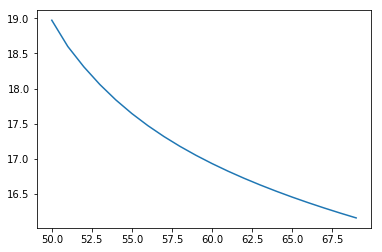

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.show()

Assuming no parameters were changed, you should reach a peak accuracy of 90% at the end of training, which is commendable. Try changing the parameters such as the length of training, and maybe some operations to see how the model behaves. Does it take much longer? How is the performance?

------------------------------------

## Want to learn more?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](https://cocl.us/ML0120EN_PAI).

Also, you can use Data Science Experience to run these notebooks faster with bigger datasets. Data Science Experience is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, DSX enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of DSX users today with a free account at [Data Science Experience](https://cocl.us/ML0120EN_DSX)This is the end of this lesson. Hopefully, now you have a deeper and intuitive understanding regarding the LSTM model. Thank you for reading this notebook, and good luck on your studies.

### Thanks for completing this lesson!

This is the end of **Logistic Regression with TensorFlow** notebook. Hopefully, now you have a deeper understanding of Logistic Regression and how its structure and flow work. Thank you for reading this notebook and good luck on your studies.

Created by: <a href = "https://br.linkedin.com/in/walter-gomes-de-amorim-junior-624726121">Walter Gomes de Amorim Junior</a> , <a href = "https://br.linkedin.com/in/walter-gomes-de-amorim-junior-624726121">Saeed Aghabozorgi</a> , <a href = "https://br.linkedin.com/in/victor-barros-2446a390">Victor Barros Costa</a>


<hr>
Copyright &copy; 2016 [Big Data University](https://bigdatauniversity.com/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).